# Soluciones de la práctica 3: verificación de predicciones

**Paso 1: extraer y procesar las predicciones del modelo meteorológico**

1. Mostrar un mapa de la humedad relativa a 2 metros para las 18 UTC

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Abrimos el fichero de las 18 UTC con ``open_dataset``. En la página de descarga se recomienda utilizar los argumentos *decode_coords* y *engine*, así que lo hacemos así:

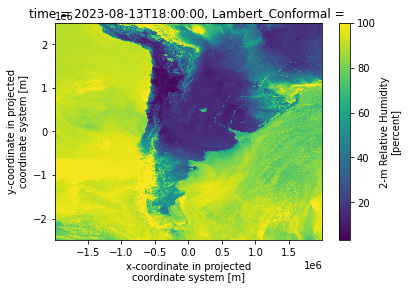

In [15]:
ds_18utc = xr.open_dataset('/MASIVO/pn31/curso_PIBM/WRFDETAR_01H_20230813_00_018.nc', 
                           decode_coords = 'all', engine = 'h5netcdf')
ds_18utc.HR2.sel(time='2023-08-13T18:00:00').plot()

2. Mostrar mapas en mosaico de la temperatura a 2 metros, la humedad relativa a 2 metros, y la velocidad del viento a 10 metros para las 9, 15 y 21 UTC.

Podemos cargar primero todos los ficheros netCDF y concatenarlos para formar un dataset que contenga todos los datos (open_mfdataset parece fallar aquí, no conozco el motivo):

In [3]:
for step in [str(i).zfill(3) for i in range(9,25)]:
    if step == "009":
        ds = xr.open_dataset('/MASIVO/pn31/curso_PIBM/WRFDETAR_01H_20230813_00_%s.nc'%step,
                            decode_coords = 'all', engine = 'h5netcdf')
    else:
        ds_step = xr.open_dataset('/MASIVO/pn31/curso_PIBM/WRFDETAR_01H_20230813_00_%s.nc'%step,
                                 decode_coords = 'all', engine = 'h5netcdf')
        ds = xr.concat([ds, ds_step], dim="time")
        ds_step.close()

/usr/local/apps/gcc/11.2.0/python/3.10.1/lib/python3.10/site-packages/ecmwflibs/__init__.py:69: UserWarning: ecmwflibs: ignoring provided 'ECCODES_DEFINITION_PATH' set to '/usr/local/apps/gcc/11.2.0/eccodes/2.28.0/share/eccodes/definitions:/usr/local/apps/global/harmonie_definitions/1.1/grib/definitions'. If you want ecmwflibs to use this environment variable, use ECMWFLIBS_ECCODES_DEFINITION_PATH instead. If you want to use your own ECCODES library, use ECMWFLIBS_ECCODES.
  warnings.warn(
/usr/local/apps/gcc/11.2.0/python/3.10.1/lib/python3.10/site-packages/ecmwflibs/__init__.py:69: UserWarning: ecmwflibs: ignoring provided 'GRIB_DEFINITION_PATH' set to '/usr/local/apps/global/harmonie_definitions/1.1/grib/definitions'. If you want ecmwflibs to use this environment variable, use ECMWFLIBS_GRIB_DEFINITION_PATH instead. If you want to use your own ECCODES library, use ECMWFLIBS_ECCODES.
  warnings.warn(


In [17]:
ds

<xarray.Dataset>
Dimensions:            (time: 16, y: 1249, x: 999)
Coordinates:
    lon                (y, x) float32 -94.33 -94.28 -94.22 ... -48.0 -47.97
    lat                (y, x) float32 -54.39 -54.4 -54.41 ... -11.65 -11.65
  * time               (time) datetime64[ns] 2023-08-13T09:00:00 ... 2023-08-14
  * x                  (x) float32 -1.996e+06 -1.992e+06 ... 1.992e+06 1.996e+06
  * y                  (y) float32 -2.496e+06 -2.492e+06 ... 2.492e+06 2.496e+06
    Lambert_Conformal  <U1 ''
Data variables:
    PP                 (time, y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    T2                 (time, y, x) float32 3.32 3.314 3.31 ... 25.8 25.76 25.67
    PSFC               (time, y, x) float32 997.9 997.9 997.8 ... 976.8 976.5
    TSLB               (time, y, x) float32 0.01001 0.01001 ... 29.67 29.53
    SMOIS              (time, y, x) float32 1.0 1.0 1.0 ... 0.09781 0.101
    ACLWDNB            (time, y, x) float32 7.445e+06 7.446e+06 ... 3.098e+07
    ACLWUPB            (time, y, x) float32 1.093e+07 1.093e+07 ... 4.111e+07
    ACSWDNB            (time, y, x) float32 0.0 0.0 0.0 ... 2.443e+07 2.442e+07
    HR2                (time, y, x) float32 78.35 78.52 78.67 ... 30.69 30.96
    dirViento10        (time, y, x) float32 242.4 242.2 242.2 ... 145.4 141.8
    magViento10        (time, y, x) float32 8.451 8.462 8.458 ... 1.897 1.783
Attributes:
    title:        Python PostProcessing for SMN WRF-ARW
    institution:  Servicio Meteorologico Nacional
    source:        OUTPUT FROM WRF V4.0 MODEL
    min_lat:      -56.853172
    min_lon:      -94.33081
    max_lat:      -11.645958
    max_lon:      -35.66919
    MAP_PROJ:     Lambert Conformal
    DX:           4000.0
    DY:           4000.0
    START_DATE:   2023-08-13 00:00:00
    Conventions:  CF-1.8

Una forma de pintar todos los mapas de golpe es mediante un bucle que vaya escogiendo cada objeto Axes, de forma que cada Axes corresponda a una hora y variable distintas:

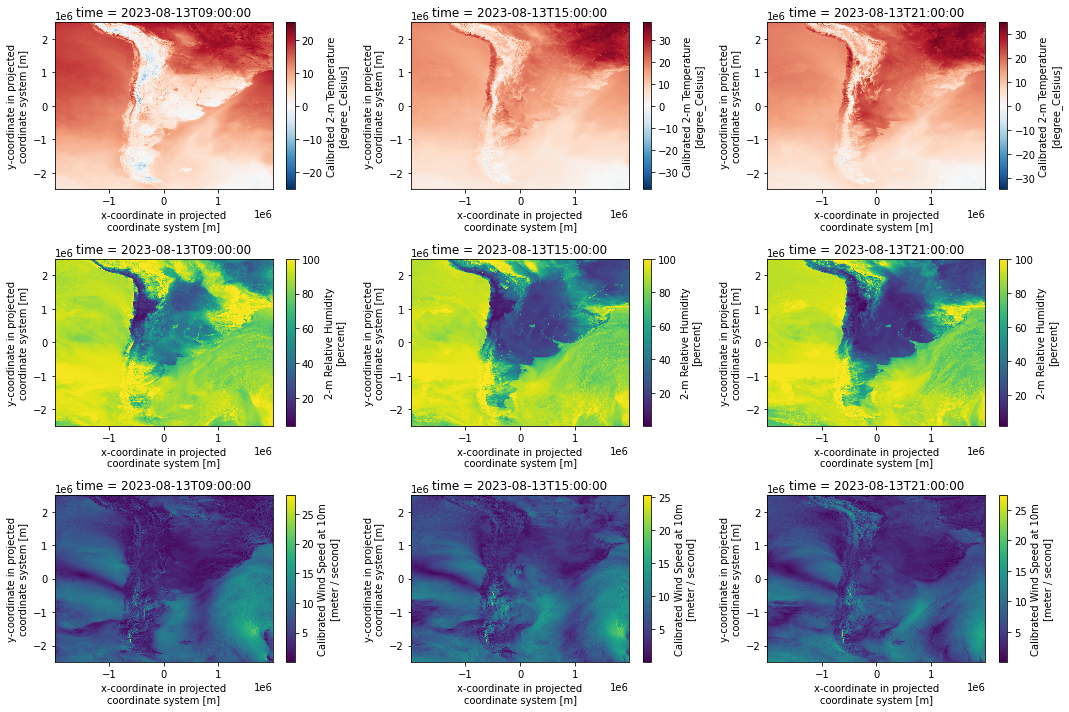

In [27]:
fig = plt.figure(figsize=[15, 10])

lst_axes = []
numx = 3
numy = 3

variables = ['T2', 'HR2', 'magViento10']
id_times = ['2023-08-13T'+h+':00:00' for h in ['09','15','21']]

for i in range(0,numx*numy):
    
    lst_axes.append(fig.add_subplot(numx,numy,i+1))
    ax = lst_axes[i]

    variable = ds[variables[int(i/3)]]
    variable.sel(time=id_times[i%3]).plot(ax=ax)

plt.tight_layout()
plt.show()

Otra alternativa es hacer un bucle más simple, que solo recorra las variables, y utilizar *Faceting* para recorrer la dimensión tiempo:

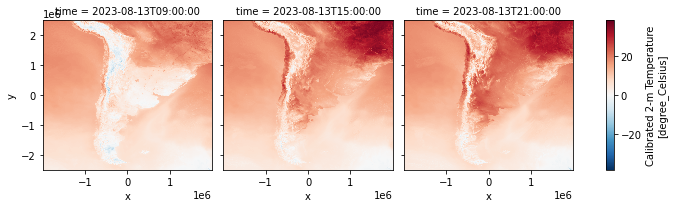

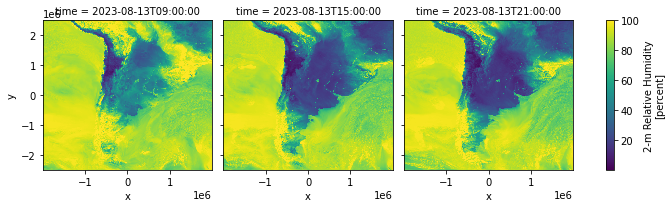

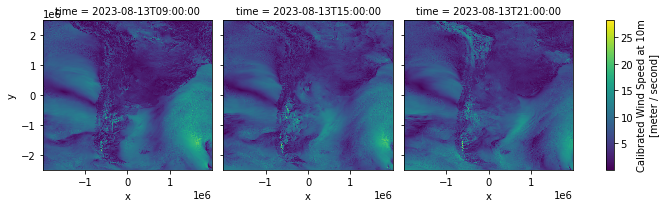

In [26]:
variables = ['T2', 'HR2', 'magViento10']

for var in variables:
    ds[var].isel(time=slice(0, 13, 6)).plot(col='time')
    
plt.show()

3. Mostrar gráficas en mosaico del corte para la latitud xx de la temperatura a 2 metros, la humedad relativa a 2 metros, y la velocidad del viento a 10 metros para las 9, 15 y 21 UTC.

Basta con eliminar la dimensión latitud, y ya sacamos las gráficas:

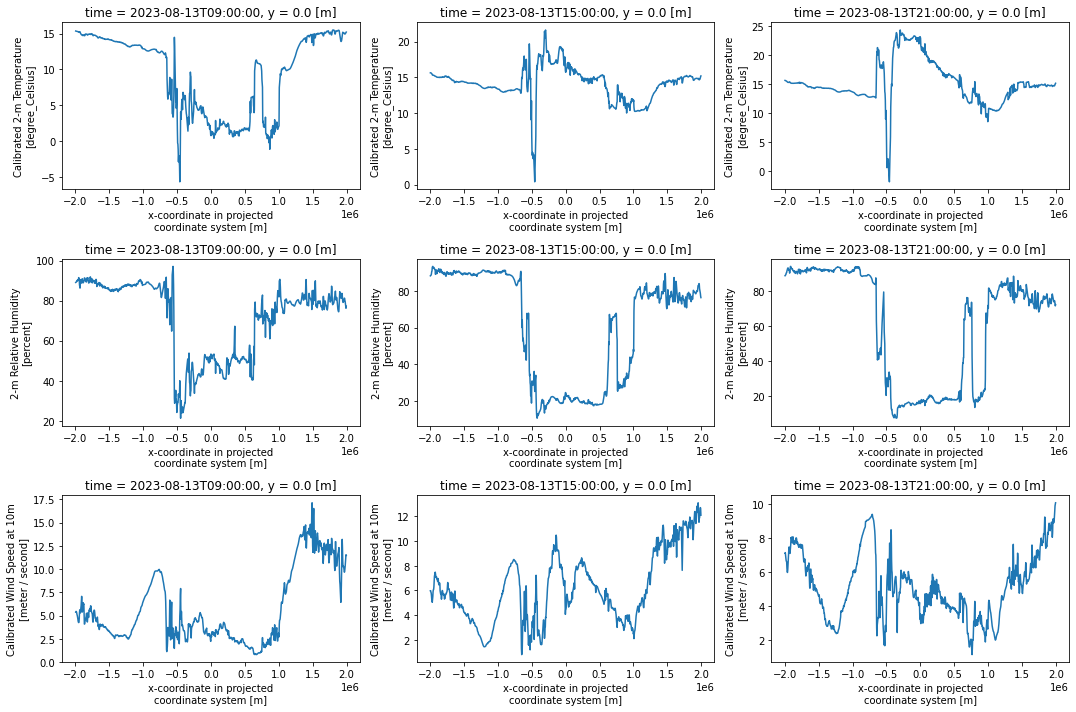

In [28]:
fig = plt.figure(figsize=[15, 10])

lst_axes = []
numx = 3
numy = 3

variables = ['T2', 'HR2', 'magViento10']
id_times = ['2023-08-13T'+h+':00:00' for h in ['09','15','21']]

for i in range(0,numx*numy):
    
    lst_axes.append(fig.add_subplot(numx,numy,i+1))
    ax = lst_axes[i]

    variable = ds[variables[int(i/3)]]
    variable.sel(time=id_times[i%3]).sel(y=100, method='nearest').plot(ax=ax)

plt.tight_layout()
plt.show()

4. Mostrar mapas con la temperatura media, máxima y mínima durante el día 13.

Podemos ejecutar cada estadística individualmente, pintando cada una por separado:

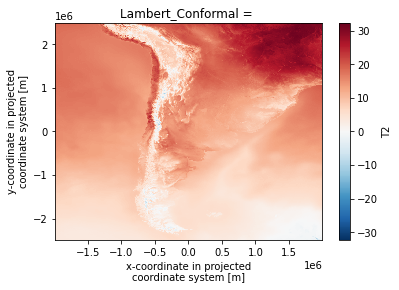

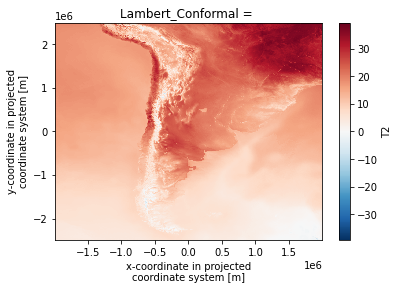

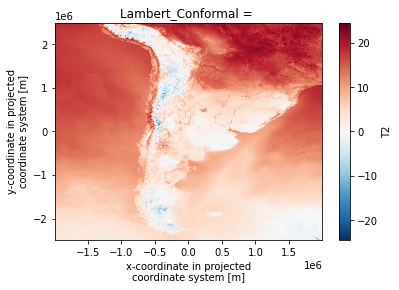

In [18]:
ds.T2.mean(dim='time').plot(size=4)
ds.T2.max(dim='time').plot(size=4)
ds.T2.min(dim='time').plot(size=4)

Una alternativa más general (aunque quizás un poco extravagante) sería crear una función general que tenga como argumento la función que queremos pintar:

In [73]:
def plot_statistic(name, func):
    '''
    Función que pinta una estadística 
    
    Parameters
    ----------
    name : str
           Título de la gráfica
    func : function
           Función a pintar
    '''
    
    func(dim='time').plot(size=4)
    plt.title(name)

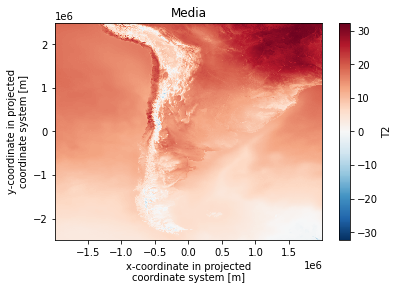

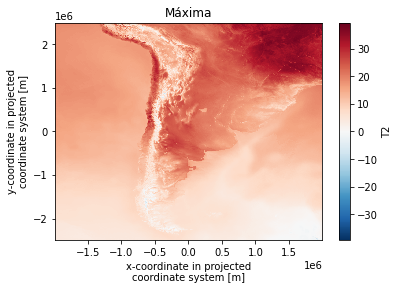

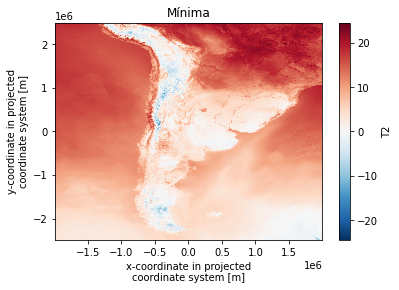

In [74]:
all_stats = {"Media": ds.T2.mean, "Máxima": ds.T2.max, "Mínima": ds.T2.min} 
for st in all_stats:
    plot_statistic(st, all_stats[st])   

4. Extraer las predicciones de temperatura a 2 metros para la estación “Aeropuerto Melilla G3” (por ejemplo)

Hay un problema para extraer las predicciones: las coordenadas son x e y, los metros desde un determinado punto, no la latitud y la longitud. Afortunadamente en uno de los tutoriales de la página de descarga (https://odp-aws-smn.github.io/documentation_wrf_det/Get_lat_lon_fecha/) se da un ejemplo de cómo transformar las coordenadas x/y a latitud/longitud.

Para ello hay que usar Cartopy, dado que el modelo meteorológico utiliza una proyección distinta, la proyección Lambert, y con Cartopy podemos hacer la transformación. El código (copiado de esa página) es este:

In [3]:
import cartopy.crs as ccrs
from datetime import datetime

In [4]:
init_year = 2023
init_month = 8
init_day = 13
init_hour = 0
INIT_DATE = datetime(init_year, init_month, init_day, init_hour)
latitude = -34.78999
longitude = -56.26628
var = 'T2'

In [8]:
# Buscamos la ubicación del punto más cercano a la latitud y longitud solicitada
# We search the closest gridpoint to the selected lat-lon
data_crs = ccrs.LambertConformal(central_longitude = ds['Lambert_Conformal'].attrs['longitude_of_central_meridian'],
                                 central_latitude = ds['Lambert_Conformal'].attrs['latitude_of_projection_origin'],
                                 standard_parallels = ds['Lambert_Conformal'].attrs['standard_parallel'])
x, y = data_crs.transform_point(longitude, latitude, src_crs=ccrs.PlateCarree())

# Seleccionamos el dato mas cercano a la latitud, longitud y fecha escogida
# We extract the value at the chosen gridpoint

forecast = ds.sel(dict(x = x, y = y), method = 'nearest')[var]

*forecast* es un array de Numpy donde ya tenemos las temperaturas de nuestra estación. Además *forecast.time* nos informa de la hora a la que corresponde cada temperatura: 

In [20]:
forecast.time

<xarray.DataArray 'time' (time: 16)>
array(['2023-08-13T09:00:00.000000000', '2023-08-13T10:00:00.000000000',
       '2023-08-13T11:00:00.000000000', '2023-08-13T12:00:00.000000000',
       '2023-08-13T13:00:00.000000000', '2023-08-13T14:00:00.000000000',
       '2023-08-13T15:00:00.000000000', '2023-08-13T16:00:00.000000000',
       '2023-08-13T17:00:00.000000000', '2023-08-13T18:00:00.000000000',
       '2023-08-13T19:00:00.000000000', '2023-08-13T20:00:00.000000000',
       '2023-08-13T21:00:00.000000000', '2023-08-13T22:00:00.000000000',
       '2023-08-13T23:00:00.000000000', '2023-08-14T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    lon                float32 -56.23
    lat                float32 -34.79
  * time               (time) datetime64[ns] 2023-08-13T09:00:00 ... 2023-08-14
    x                  float32 8e+05
    y                  float32 -1.2e+04
    Lambert_Conformal  <U1 ''
Attributes:
    long_name:      hours since 2023-08-13 00:00:00
    standard_name:  time
    axis:           T

In [13]:
forecast.values

array([ 5.207428 ,  4.976166 ,  4.6733093,  5.8909607,  8.144379 ,
       10.019928 , 11.533813 , 12.767242 , 14.006592 , 14.976318 ,
       15.535248 , 15.827026 , 15.614471 , 14.165314 , 13.019592 ,
       12.150909 ], dtype=float32)

Transformamos las horas de tipo cadena (string) a datetime y restamos 3 horas (dado que Uruguay tiene el huso horario GMT-3):

In [25]:
lead_times = pd.to_datetime(forecast.time, "%Y-%m-%dT%H:%M%s") - pd.Timedelta(hours=3)
lead_times

DatetimeIndex(['2023-08-13 06:00:00', '2023-08-13 07:00:00',
               '2023-08-13 08:00:00', '2023-08-13 09:00:00',
               '2023-08-13 10:00:00', '2023-08-13 11:00:00',
               '2023-08-13 12:00:00', '2023-08-13 13:00:00',
               '2023-08-13 14:00:00', '2023-08-13 15:00:00',
               '2023-08-13 16:00:00', '2023-08-13 17:00:00',
               '2023-08-13 18:00:00', '2023-08-13 19:00:00',
               '2023-08-13 20:00:00', '2023-08-13 21:00:00'],
              dtype='datetime64[ns]', freq=None)

Y emparejamos fechas con temperaturas en un dataframe, para manejarlo más cómodamente:

In [48]:
df_fcst = pd.DataFrame({'Fecha': lead_times, 't2m pred': forecast.values})
df_fcst

Fecha   t2m pred
0  2023-08-13 06:00:00   5.207428
1  2023-08-13 07:00:00   4.976166
2  2023-08-13 08:00:00   4.673309
3  2023-08-13 09:00:00   5.890961
4  2023-08-13 10:00:00   8.144379
5  2023-08-13 11:00:00  10.019928
6  2023-08-13 12:00:00  11.533813
7  2023-08-13 13:00:00  12.767242
8  2023-08-13 14:00:00  14.006592
9  2023-08-13 15:00:00  14.976318
10 2023-08-13 16:00:00  15.535248
11 2023-08-13 17:00:00  15.827026
12 2023-08-13 18:00:00  15.614471
13 2023-08-13 19:00:00  14.165314
14 2023-08-13 20:00:00  13.019592
15 2023-08-13 21:00:00  12.150909

**Paso 2: formateo de las observaciones**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import cartopy as ccrs

Cargamos el fichero Excel en un dataframe de pandas. Notar que d_all es un diccionario de dataframes (uno por cada pestaña del fichero Excel):

In [5]:
d_all = pd.read_excel("inumet_20230813.xlsx", sheet_name=None)

In [6]:
type(d_all)

dict

In [7]:
d_all.keys()

dict_keys(['metadatos', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20'])

d_all.metadatos (la primera pestaña) es un dataframe de pandas con los metadatos de las estaciones:

In [9]:
d_all['metadatos'][0:5]

Nombre      Depto.  Latitud  Longitud Altitud
0  Aeropuerto de Carmelo     Colonia -3396542  -5832606       -
1  Aeropuerto Melilla G3  Montevideo -3478999  -5626628   48.33
2           Antartida G3           - -6210100  -5854100   17.00
3             Artigas G3     Artigas -3039911  -5651267  120.88
4           Atlántida G3   Canelones -3477972  -5575277    8.75

Tenemos otros 15 dataframes más, uno por cada hora:

In [10]:
d_all['06'][0:6]

Estación Viento [Dir./(Km/h)]  Temperatura del Aire [ºC]  \
0  Aeropuerto Melilla G3                  N/8                        0.0   
1             Colonia G3               NNE/11                        1.5   
2             Durazno G3                 NW/9                       -0.8   
3    Laguna del Sauce G3                NW/12                        4.9   
4           Lavalleja G3                ENE/2                       -3.9   
5                Melo G3                NNW/2                       -0.1   

   Temperatura de Punto de Rocío [ºC]  Humedad relativa [%]  \
0                                -1.9                  87.0   
1                                -2.8                  73.0   
2                                -3.0                  85.0   
3                                 0.5                  74.0   
4                                -4.6                  95.0   
5                                -1.1                  93.0   

   Precipitación Acumulada Horaria [mm]  \
0                                   0.0   
1                                   0.0   
2                                   0.0   
3                                   0.0   
4                                   0.0   
5                                   0.0   

  Presión Atmosférica a Nivel del Mar [hPa]  
0                                    1025.9  
1                                    1025.8  
2                                    1026.6  
3                                    1025.7  
4                                    1026.3  
5                                    1026.7

Añadimos una columna llamada Fecha tomando la hora de cada pestaña:

In [11]:
date_file = '2023-08-13'
for hour in [str(i).zfill(2) for i in range(6,21)]:
    d_all[hour]['Fecha'] = pd.Timestamp(date_file + 'T' + hour)

In [13]:
d_all['08']

Estación Viento [Dir./(Km/h)]  Temperatura del Aire [ºC]  \
0   Aeropuerto Melilla G3                 N/10                       -0.2   
1              Artigas G3                SSE/5                        0.1   
2            Atlántida G3               NNW/13                        2.6   
3              Colonia G3                 N/14                        1.7   
4              Durazno G3                  S/2                       -1.3   
5              Florida G3                 NE/5                       -2.9   
6     Laguna del Sauce G3                WNW/8                        3.2   
7            Lavalleja G3                NNE/2                       -3.4   
8                 Melo G3                  N/3                        1.0   
9             Mercedes G3                 SE/7                       -2.8   
10   Minas de Corrales G4                NNE/4                        0.9   
11   Paso de los Toros G3                WNW/5                        1.1   
12            Paysandú G3                  N/9                        1.6   
13               Prado G3                NNE/4                        3.0   
14      Punta del Este G4                WNW/7                        8.2   
15              Rivera G3                NNE/4                       -0.2   
16               Rocha G3                NNW/6                        4.2   
17               Salto G3                NNE/3                        0.4   
18         San Jacinto G3                NNW/7                       -0.5   
19            San José G4                NW/11                       -2.1   
20          Tacuarembó G3                 NW/6                       -0.1   
21      Treinta y Tres G3                 W/12                        0.8   
22            Trinidad G4                WSW/5                        1.5   
23               Young G3                  N/6                        1.8   

    Temperatura de Punto de Rocío [ºC]  Humedad relativa [%]  \
0                                 -2.5                  85.0   
1                                 -1.3                  90.0   
2                                 -1.7                  73.0   
3                                 -2.8                  72.0   
4                                 -3.5                  85.0   
5                                 -4.2                  91.0   
6                                  0.2                  80.0   
7                                 -4.2                  95.0   
8                                 -0.7                  89.0   
9                                 -4.1                  92.0   
10                                -0.4                  89.0   
11                                -2.2                  78.0   
12                                -2.4                  75.0   
13                                -0.3                  79.0   
14                                 4.4                  77.0   
15                                -0.5                  98.0   
16                                 0.6                  78.0   
17                                -0.3                  96.0   
18                                -2.5                  86.0   
19                                -4.1                  86.0   
20                                -1.2                  92.0   
21                                -1.7                  84.0   
22                                -3.1                  72.0   
23                                -2.7                  72.0   

    Precipitación Acumulada Horaria [mm]  \
0                                    0.0   
1                                    0.0   
2                                    0.0   
3                                    0.0   
4                                    0.0   
5                                    0.0   
6                                    0.0   
7                                    0.0   
8                                    0.0   
9                                    0.0   
10    

Ahora concatenamos todos los dataframes creando uno más grande, mejor estructurado que antes. Así tenemos la información en un único dataframe, no en un diccionario de muchos más pequeños:

In [33]:
df = pd.DataFrame()
for hour in [str(i).zfill(2) for i in range(6,21)]:
    df = pd.concat([df, dfall[hour]])

Unimos el dataframe con los metadatos:

In [34]:
df = pd.merge(df, dfall['metadatos'], left_on='Estación', right_on='Nombre')

In [35]:
df.Latitud = df.Latitud/100000.0  # Excel los lee como enteros en este caso (problema con el punto como separador)
df.Longitud = df.Longitud/100000.0

In [36]:
df[10:20]

Estación Viento [Dir./(Km/h)]  Temperatura del Aire [ºC]  \
10  Aeropuerto Melilla G3               NNW/21                       14.3   
11  Aeropuerto Melilla G3               NNW/21                       13.8   
12  Aeropuerto Melilla G3               NNW/17                       12.1   
13  Aeropuerto Melilla G3                 N/15                       10.5   
14  Aeropuerto Melilla G3                 N/15                        9.7   
15             Colonia G3               NNE/11                        1.5   
16             Colonia G3                 N/14                        1.6   
17             Colonia G3                 N/14                        1.7   
18             Colonia G3                 N/13                        4.7   
19             Colonia G3                 N/13                        8.6   

    Temperatura de Punto de Rocío [ºC]  Humedad relativa [%]  \
10                                -2.5                  31.0   
11                                -1.9                  34.0   
12                                -1.8                  38.0   
13                                -0.8                  46.0   
14                                -0.4                  49.0   
15                                -2.8                  73.0   
16                                -2.3                  75.0   
17                                -2.8                  72.0   
18                                -1.7                  63.0   
19                                -0.6                  52.0   

    Precipitación Acumulada Horaria [mm]  \
10                                   0.0   
11                                   0.0   
12                                   0.0   
13                                   0.0   
14                                   0.0   
15                                   0.0   
16                                   0.0   
17                                   0.0   
18                                   0.0   
19                                   0.0   

   Presión Atmosférica a Nivel del Mar [hPa]               Fecha  \
10                                    1020.9 2023-08-13 16:00:00   
11                                    1020.3 2023-08-13 17:00:00   
12                                    1019.9 2023-08-13 18:00:00   
13                                    1019.8 2023-08-13 19:00:00   
14                                    1020.0 2023-08-13 20:00:00   
15                                    1025.8 2023-08-13 06:00:00   
16                                    1026.1 2023-08-13 07:00:00   
17                                    1026.5 2023-08-13 08:00:00   
18                                    1026.4 2023-08-13 09:00:00   
19                                    1026.2 2023-08-13 10:00:00   

                   Nombre      Depto.   Latitud  Longitud Altitud  
10  Aeropuerto Melilla G3  Montevideo -34.78999 -56.26628   48.33  
11  Aeropuerto Melilla G3  Montevideo -34.78999 -56.26628   48.33  
12  Aeropuerto Melilla G3  Montevideo -34.78999 -56.26628   48.33  
13  Aeropuerto Melilla G3  Montevideo -34.78999 -56.26628   48.33  
14  Aeropuerto Melilla G3  Montevideo -34.78999 -56.26628   48.33  
15             Colonia G3     Colonia -34.45182 -57.76804   22.00  
16             Colonia G3     Colonia -34.45182 -57.76804   22.00  
17             Colonia G3     Colonia -34.45182 -57.76804   22.00  
18             Colonia G3     Colonia -34.45182 -57.76804   22.00  
19             Colonia G3     Colonia -34.45182 -57.76804   22.00

In [37]:
df.dtypes

Estación                                             object
Viento [Dir./(Km/h)]                                 object
Temperatura del Aire [ºC]                           float64
Temperatura de Punto de Rocío [ºC]                  float64
Humedad relativa [%]                                float64
Precipitación Acumulada Horaria [mm]                float64
Presión Atmosférica a Nivel del Mar [hPa]            object
Fecha                                        datetime64[ns]
Nombre                                               object
Depto.                                               object
Latitud                                             float64
Longitud                                            float64
Altitud                                              object
dtype: object

**Paso 3: verificación de las predicciones**

1. Crear un gráfico que muestre la evolución de la temperatura a 2 metros observada y predicha para la estación “Aeropuerto Melilla G3” (por ejemplo) durante el día 13.

In [47]:
df_obs = df[df['Estación']=='Aeropuerto Melilla G3']

Nos basta con unir los dataframes de predicciones y observaciones obtenidos antes:

In [49]:
df_verif = pd.merge(df_obs, df_fcst, on="Fecha")
df_verif

Estación Viento [Dir./(Km/h)]  Temperatura del Aire [ºC]  \
0   Aeropuerto Melilla G3                  N/8                        0.0   
1   Aeropuerto Melilla G3                  N/6                        1.5   
2   Aeropuerto Melilla G3                 N/10                       -0.2   
3   Aeropuerto Melilla G3               NNW/10                        3.0   
4   Aeropuerto Melilla G3               NNW/10                        7.5   
5   Aeropuerto Melilla G3                NW/15                       10.4   
6   Aeropuerto Melilla G3                NW/12                       11.3   
7   Aeropuerto Melilla G3               NNW/13                       12.6   
8   Aeropuerto Melilla G3               NNW/17                       13.6   
9   Aeropuerto Melilla G3               NNW/20                       14.1   
10  Aeropuerto Melilla G3               NNW/21                       14.3   
11  Aeropuerto Melilla G3               NNW/21                       13.8   
12  Aeropuerto Melilla G3               NNW/17                       12.1   
13  Aeropuerto Melilla G3                 N/15                       10.5   
14  Aeropuerto Melilla G3                 N/15                        9.7   

    Temperatura de Punto de Rocío [ºC]  Humedad relativa [%]  \
0                                 -1.9                  87.0   
1                                 -1.5                  81.0   
2                                 -2.5                  85.0   
3                                 -0.8                  77.0   
4                                  0.9                  63.0   
5                                 -0.6                  47.0   
6                                 -1.0                  42.0   
7                                 -2.7                  35.0   
8                                 -2.8                  32.0   
9                                 -2.6                  31.0   
10                                -2.5                  31.0   
11                                -1.9                  34.0   
12                                -1.8                  38.0   
13                                -0.8                  46.0   
14                                -0.4                  49.0   

    Precipitación Acumulada Horaria [mm]  \
0                                    0.0   
1                                    0.0   
2                                    0.0   
3                                    0.0   
4                                    0.0   
5                                    0.0   
6                                    0.0   
7                                    0.0   
8                                    0.0   
9                                    0.0   
10                                   0.0   
11                                   0.0   
12                                   0.0   
13                                   0.0   
14                                   0.0   

   Presión Atmosférica a Nivel del Mar [hPa]               Fecha  \
0                                     1025.9 2023-08-13 06:00:00   
1                                     1025.8 2023-08-13 07:00:00   
2                                     1026.4 2023-08-13 08:00:00   
3                                     1026.9 2023-08-13 09:00:00   
4                                     1026.9 2023-08-13 10:00:00   
5                                     1027.0 2023-08-13 11:00:00   
6                                     1026.0 2023-08-13 12:00:00   
7                                     1024.0 2023-08-13 13:00:00   
8                                     1023.2 2023-08-13 14:00:00   
9                                     1022.0 2023-08-13 15:00:00   
10                                    1020.9 2023-08-13 16:00:00   
11                                    1020.3 2023-08-13 17:00:00   
12                                    1019.9 2023-08-13 18:00:00   
13                                    1019.8 2023-08-13 19:00:00   
14                                

Ya podemos dibujar la gráfica:

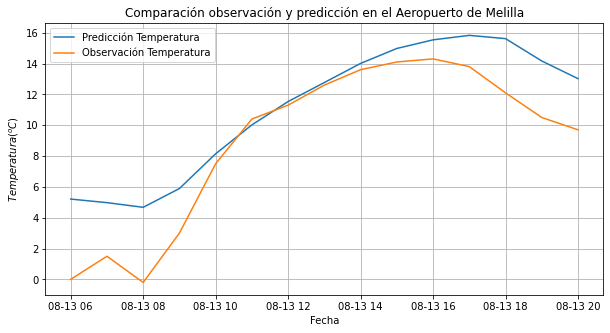

In [57]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_ylabel('$Temperatura (^{o}C)$')
ax.set_xlabel('Fecha')
ax.set_title("Comparación observación y predicción en el Aeropuerto de Melilla")
ax.plot(df_verif['Fecha'], df_verif['t2m pred'], label='Predicción Temperatura')
ax.plot(df_verif['Fecha'], df_verif['Temperatura del Aire [ºC]'], label='Observación Temperatura')
ax.grid()
ax.legend()

Observamos que el modelo infraestima la temperatura máxima y mínima. Esto es bastante habitual en un modelo meteorológico: notar que cada punto de un modelo representa un área bastante grande, mientras que una observación es puntual. Suele haber problemas de representatividad. Esto se puede corregir en gran medida con un programa de postproceso.

2. Calcular el sesgo y el error cuadrático medio de la predicción para esta estación.

In [62]:
df['error'] = df_verif['t2m pred'] - df_verif['Temperatura del Aire [ºC]']
sesgo = df.error.mean()
rmse = np.sqrt((df.error**2).mean())
print("sesgo=%f"%sesgo)
print("rmse=%f"%rmse)

sesgo=2.143853
rmse=2.772770


Efectivamente el sesgo es de 2 grados (como ya intuíamos al ver la gráfica). De todas formas esto ha ocurrido un día concreto: para sacar buenas conclusiones habría que verificar un periodo mucho más largo, y para más estaciones.